# 1. Preprocessing

In [1]:
from load_data import load_splited_data

(X_train_german_sen, X_test_german_sen,
        X_train_german_word, X_test_german_word,
        y_train_german1, y_test_german1,
        y_train_german2, y_test_german2,
        X_train_socc_sen, X_test_socc_sen,
        X_train_socc_word, X_test_socc_word,
        y_train_socc, y_test_socc) = load_splited_data(training_size=0.7)

In [2]:
print(X_train_german_sen.shape)
print(X_train_german_word.shape)
print(y_train_german1.shape)
print(y_train_german2.shape)
print('-------------')
print(X_train_socc_sen.shape)
print(X_train_socc_word.shape)
print(y_train_socc.shape)

(328, 768)
(328, 64, 300)
(328,)
(328,)
-------------
(730, 768)
(730, 1024, 300)
(730,)


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = 'cpu'

# 2.1 Define GRU Model for Sentence Embedding

In [16]:
class GRUNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers):
        super(GRUNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        # GRU layer
        self.gru = nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True)
        # full connective layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Sentence Embedding Data doesn't have sequence length information, vector need to be unsqueeze
        x = x.unsqueeze(1)
        # print(x.shape)
        h0 = torch.zeros(self.n_layers, x.size(0), self.hidden_dim).to(device)
        # print(h0.shape)
        
        out, _ = self.gru(x, h0)

        out = self.fc(out[:, -1, :])
        return out

# 2.2 Sentence Embedding DataLoader

- German sentence embedding with expert 1 label

In [5]:
X_train_tensor = torch.tensor(X_train_german_sen).float()
y_train_tensor = torch.tensor(y_train_german1).float()

X_test_tensor = torch.tensor(X_test_german_sen).float()
y_test_tensor = torch.tensor(y_test_german1).float()

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

- German sentence embedding with expert 2 label

In [31]:
X_train_tensor = torch.tensor(X_train_german_sen).float()
y_train_tensor = torch.tensor(y_train_german2).float()

X_test_tensor = torch.tensor(X_test_german_sen).float()
y_test_tensor = torch.tensor(y_test_german2).float()

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

- SOCC sentence embedding

In [17]:
X_train_tensor = torch.tensor(X_train_socc_sen).float()
y_train_tensor = torch.tensor(y_train_socc).float()

X_test_tensor = torch.tensor(X_test_socc_sen).float()
y_test_tensor = torch.tensor(y_test_socc).float()

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

# 2.3 Training Model and Evaluation

In [18]:
# model parameters
input_dim = 768  
hidden_dim = 128 
output_dim = 2  # binary classification
n_layers = 2 

# 初始化模型
model = GRUNet(input_dim, hidden_dim, output_dim, n_layers)
model.to(device)

# 训练模型
n_epochs = 10  # 迭代次数

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 训练过程中记录预测结果
predicted_labels = []
true_labels = []

for epoch in range(n_epochs):
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # 清除梯度
        optimizer.zero_grad()
        # print('===============')
        # print(inputs.shape)
        # print(inputs)
        # print(labels.shape)
        # print(labels)
        # print('===============')
        labels = labels.long()  

        # 前向传播
        outputs = model(inputs)

        # 计算损失
        loss = criterion(outputs, labels)

        # 反向传播和优化
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}/{n_epochs} Loss: {loss.item()}')

# 测试模型的准确度（假设test_loader已经准备好）
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(true_labels)
print(predicted_labels)

# 计算准确度、精确度、召回率和F1分数
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

Epoch 1/10 Loss: 0.5510898232460022
Epoch 2/10 Loss: 0.5487503409385681
Epoch 3/10 Loss: 0.48357024788856506
Epoch 4/10 Loss: 0.2979651987552643
Epoch 5/10 Loss: 0.4396308660507202
Epoch 6/10 Loss: 0.41503188014030457
Epoch 7/10 Loss: 0.33446353673934937
Epoch 8/10 Loss: 0.40156733989715576
Epoch 9/10 Loss: 0.2837654948234558
Epoch 10/10 Loss: 0.27975863218307495
[1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0

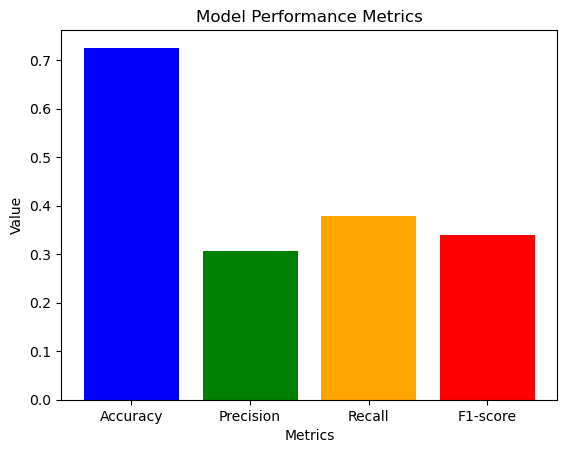

Accuracy: 0.7252396166134185
Precision: 0.3055555555555556
Recall: 0.3793103448275862
F1 Score: 0.3384615384615385


In [19]:
import matplotlib.pyplot as plt

# 绘制柱状图
labels = ['Accuracy', 'Precision', 'Recall', 'F1-score']
values = [accuracy, precision, recall, f1]

plt.bar(labels, values, color=['blue', 'green', 'orange', 'red'])
plt.xlabel('Metrics')
plt.ylabel('Value')
plt.title('Model Performance Metrics')
plt.show()

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

# 3.1 Word Embedding DataLoader

- German Word embedding with expert 1 label

In [18]:
X_train_tensor = torch.tensor(X_train_german_word).float()
y_train_tensor = torch.tensor(y_train_german1).float()

X_test_tensor = torch.tensor(X_test_german_word).float()
y_test_tensor = torch.tensor(y_test_german1).float()

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

- German Word embedding with expert 2 label

In [37]:
X_train_tensor = torch.tensor(X_train_german_word).float()
y_train_tensor = torch.tensor(y_train_german2).float()

X_test_tensor = torch.tensor(X_test_german_word).float()
y_test_tensor = torch.tensor(y_test_german2).float()

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

- SOCC Word embedding

In [16]:
X_train_tensor = torch.tensor(X_train_socc_word).float()
y_train_tensor = torch.tensor(y_train_socc).float()

X_test_tensor = torch.tensor(X_test_socc_word).float()
y_test_tensor = torch.tensor(y_test_socc).float()

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

# 3.2 Training Model and Evaluation

In [30]:
class GRUNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers):
        super(GRUNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        # GRU layer
        self.gru = nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True)
        # full connective layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # print(x.shape)
        h0 = torch.zeros(self.n_layers, x.size(0), self.hidden_dim).to(device)
        # print(h0.shape)

        out, _ = self.gru(x, h0)

        out = self.fc(out[:, -1, :])
        return out

In [31]:
# model parameters
input_dim = 300
hidden_dim = 128
output_dim = 2  # binary classification
n_layers = 2

# 初始化模型
model = GRUNet(input_dim, hidden_dim, output_dim, n_layers)
model.to(device)

# 训练模型
n_epochs = 10  # 迭代次数

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 训练过程中记录预测结果
predicted_labels = []
true_labels = []

for epoch in range(n_epochs):
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # 清除梯度
        optimizer.zero_grad()
        # print('===============')
        # print(inputs.shape)
        # print(inputs)
        # print(labels.shape)
        # print(labels)
        # print('===============')
        labels = labels.long()

        # 前向传播
        outputs = model(inputs)

        # 计算损失
        loss = criterion(outputs, labels)

        # 反向传播和优化
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}/{n_epochs} Loss: {loss.item()}')

# 测试模型的准确度（假设test_loader已经准备好）
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(true_labels)
print(predicted_labels)

# 计算准确度、精确度、召回率和F1分数
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

Epoch 1/10 Loss: 0.5653097033500671
Epoch 2/10 Loss: 0.5719391107559204
Epoch 3/10 Loss: 0.2750597298145294
Epoch 4/10 Loss: 0.41016003489494324
Epoch 5/10 Loss: 0.41573235392570496
Epoch 6/10 Loss: 0.724932074546814
Epoch 7/10 Loss: 0.5625975131988525
Epoch 8/10 Loss: 0.3998854160308838
Epoch 9/10 Loss: 0.2933255434036255
Epoch 10/10 Loss: 0.5773494839668274
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

y:\Anaconda\envs\comp7065\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


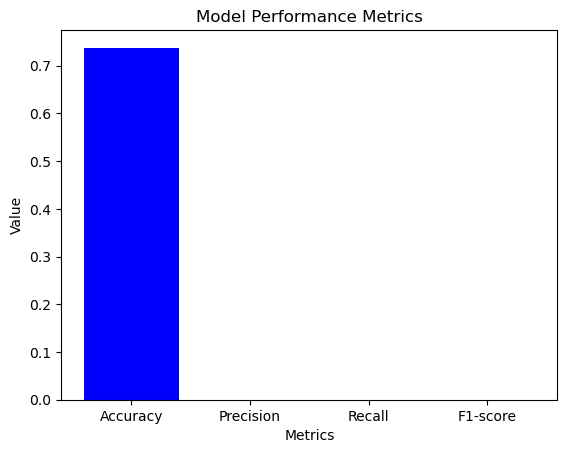

Accuracy: 0.7375886524822695
Precision: 0.0
Recall: 0.0
F1 Score: 0.0


In [29]:
import matplotlib.pyplot as plt

# 绘制柱状图
labels = ['Accuracy', 'Precision', 'Recall', 'F1-score']
values = [accuracy, precision, recall, f1]

plt.bar(labels, values, color=['blue', 'green', 'orange', 'red'])
plt.xlabel('Metrics')
plt.ylabel('Value')
plt.title('Model Performance Metrics')
plt.show()

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

# 4. Application

In [20]:
from sklearn.model_selection import train_test_split
import numpy as np

cyberbullying_sen_emb = np.load("./cyberbullying_data/cyberbullying_sen_emb.npy")
cyberbullying_word_emb = np.load("./cyberbullying_data/cyberbullying_word_emb.npy")
cyberbullying_label = np.load("./cyberbullying_data/cyberbullying_label.npy")

# (X_train_cyberbullying_sen, X_test_cyberbullying_sen, y_train_cyberbullying, y_test_cyberbullying) = train_test_split(cyberbullying_sen_emb,cyberbullying_label,train_size=0.7, random_state=42)

In [21]:
X_test_tensor = torch.tensor(cyberbullying_sen_emb).float()
y_test_tensor = torch.tensor(cyberbullying_label).float()

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [22]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(true_labels)
print(predicted_labels)

accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

[1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

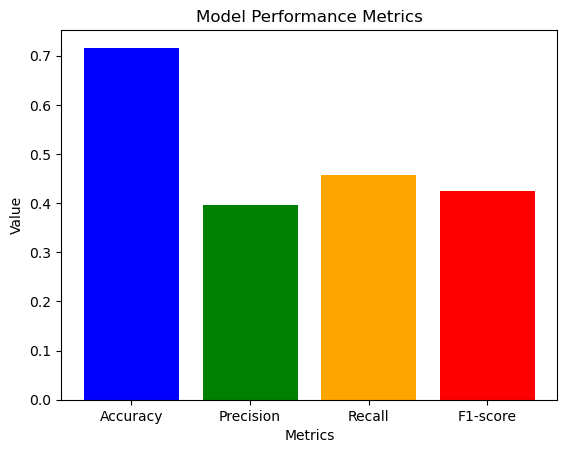

Accuracy: 0.7162534435261708
Precision: 0.3958333333333333
Recall: 0.4578313253012048
F1 Score: 0.4245810055865922


In [23]:
import matplotlib.pyplot as plt

labels = ['Accuracy', 'Precision', 'Recall', 'F1-score']
values = [accuracy, precision, recall, f1]

plt.bar(labels, values, color=['blue', 'green', 'orange', 'red'])
plt.xlabel('Metrics')
plt.ylabel('Value')
plt.title('Model Performance Metrics')
plt.show()

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')